# Fitting an ODE model to longitudinal data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import string
import pickle
from tqdm import tqdm
from datetime import datetime
#from lmfit import minimize, Parameters
#import multiprocess as mp

# Import my own libraries
import myUtils as utils
from odeModelClass import ODEModel
from odeModels import create_model
#from fittingUtils import residual, compute_r_sq, load_fit, generate_fitSummaryDf, perform_bootstrap, \
#                            compute_confidenceInterval_prediction, compute_confidenceInterval_parameters

### Cell cycle model

In [2]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
#myModel.SetParams(G10=0.01, S0=0, SD0=0, G20=0, G2D0=0, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,50,1,0],[50,100,0,1],[100,200,0.75,0.5],[200,300,0.5,0.75]])
# myModel.Simulate(treatmentScheduleList=[[0,320,0,0]], method="BDF")
myModel.Trim(dt=5.)
# myModel.Plot(plotPops=True)

In [3]:
data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

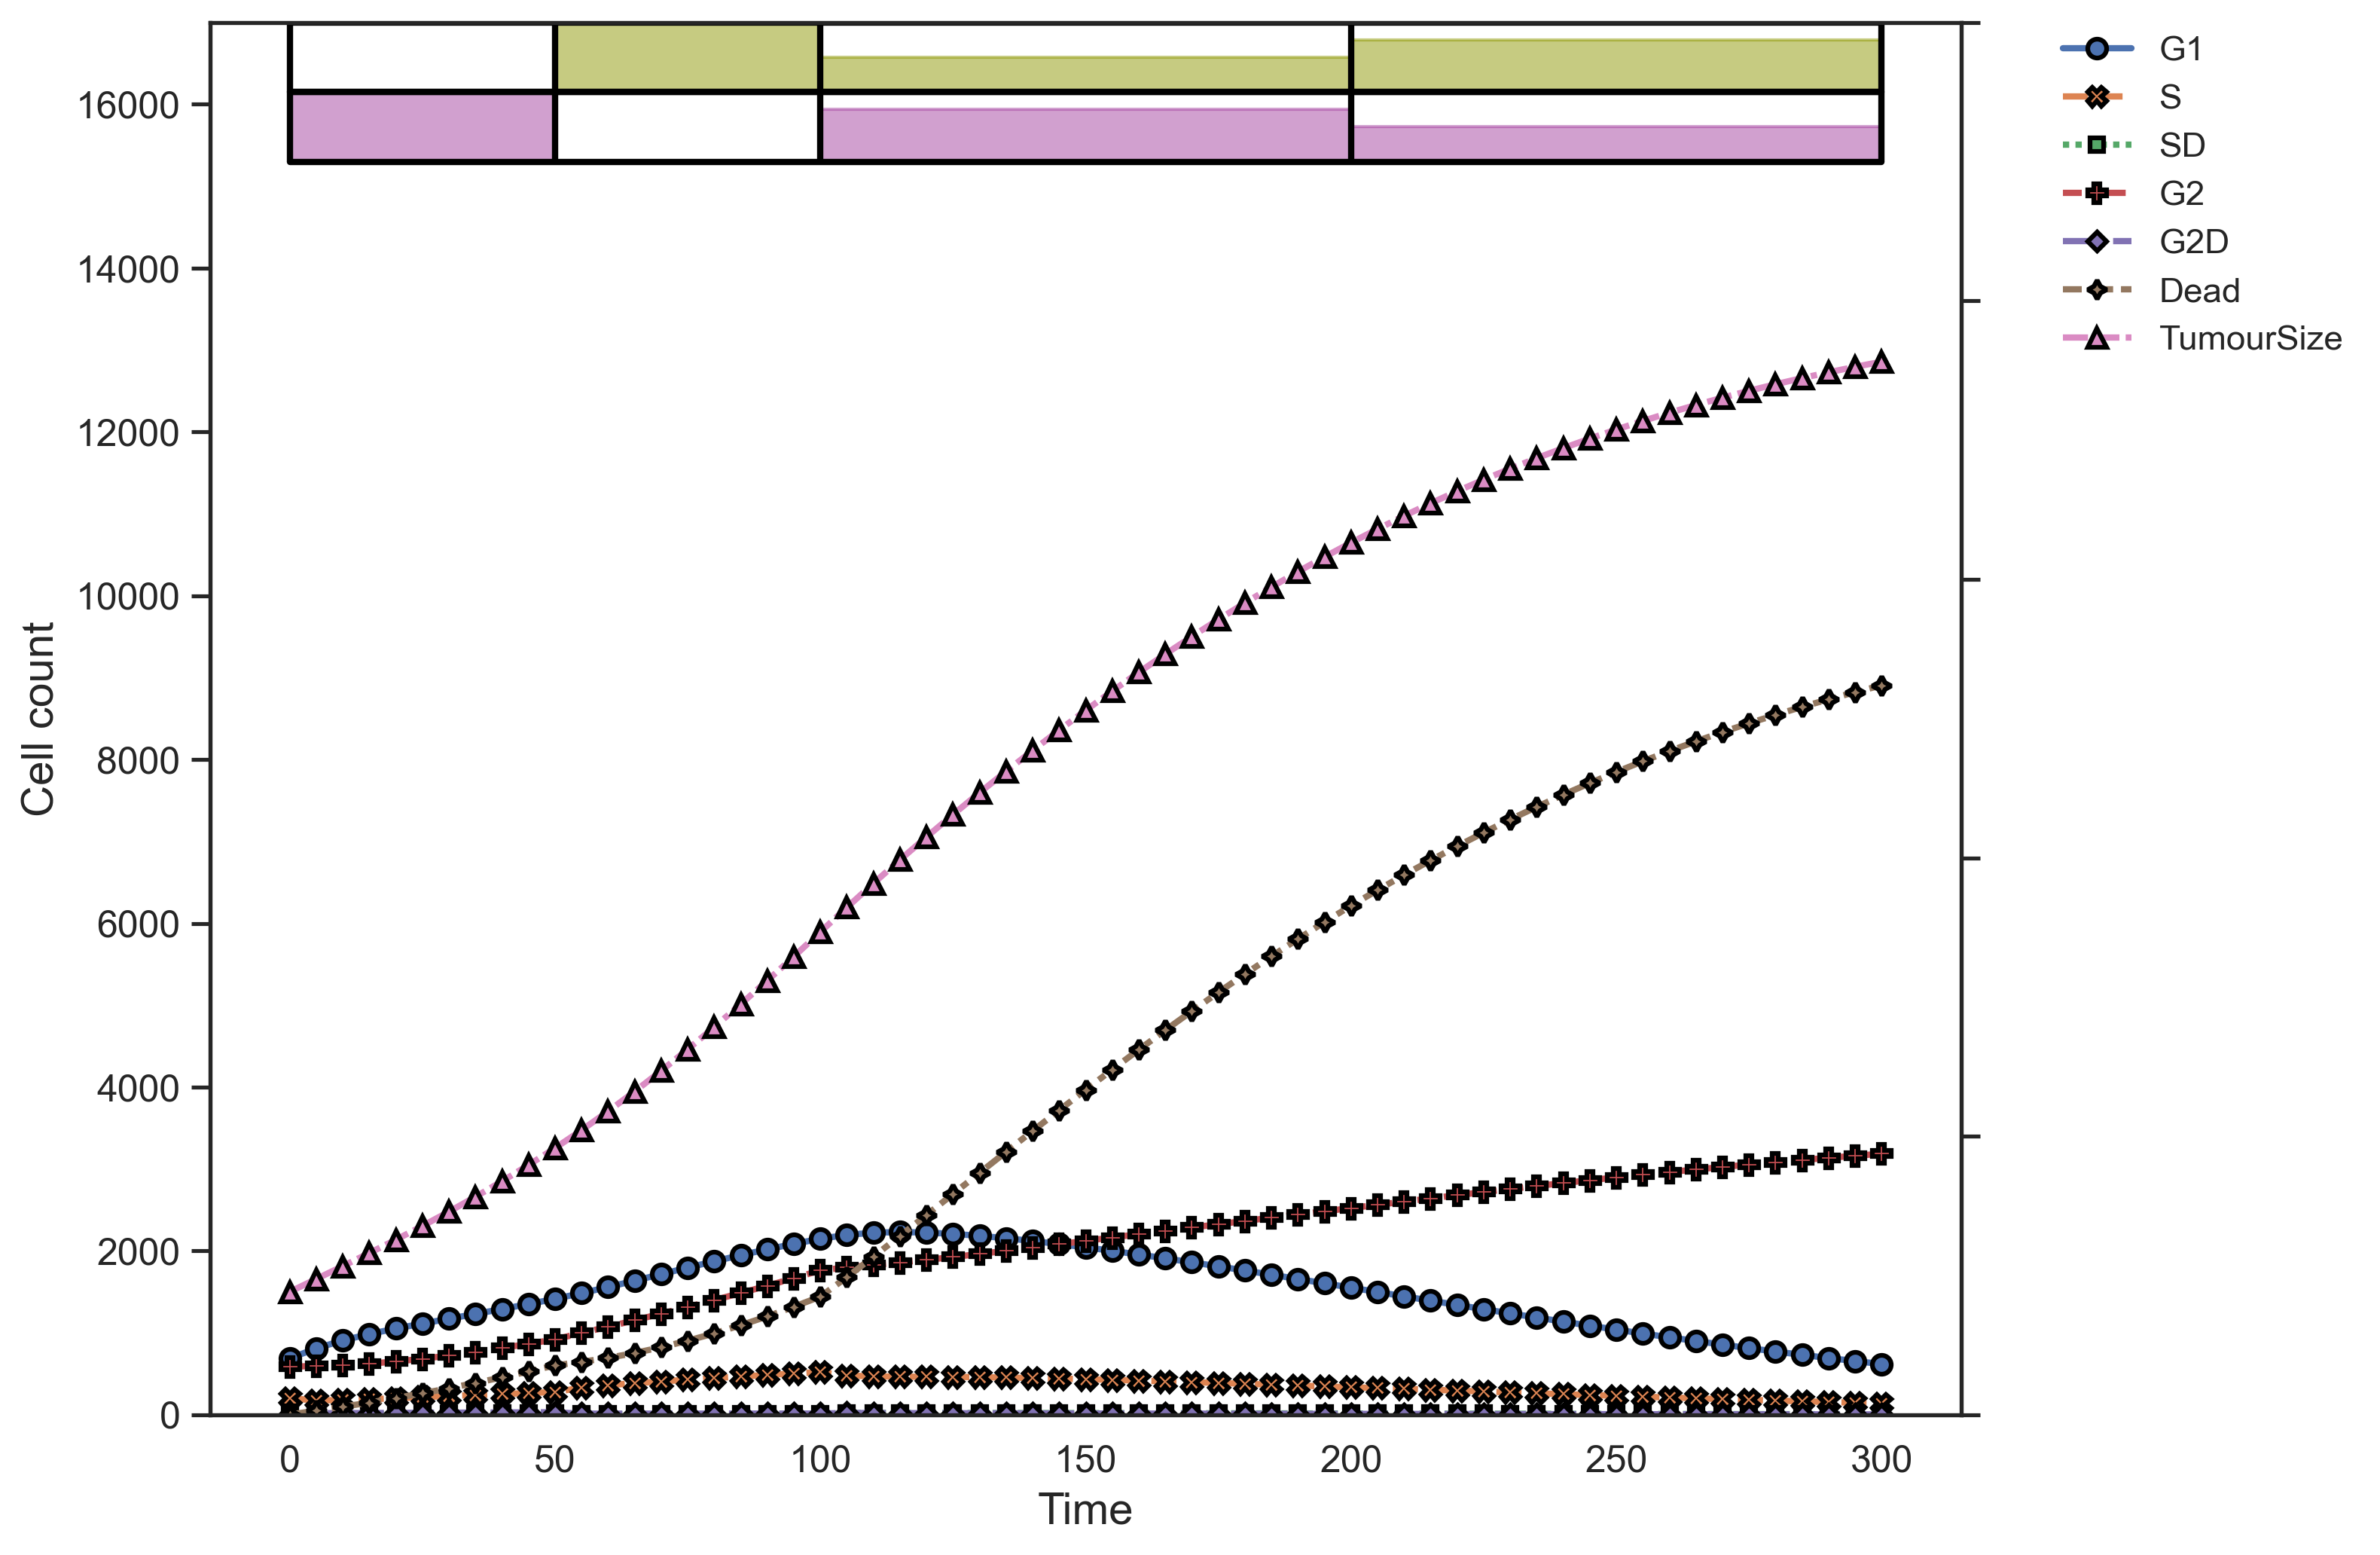

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()


In [5]:
data_df_wide

,Time,G1,S,SD,G2,G2D,Dead,A1,TumourSize,Drug1_Concentration,Drug2_Concentration
0,0.0,687.000000,199.500000,23.550000,586.500000,3.450000,0.000000,0.000000,1500.000000,1.0,0.00
1,5.0,809.595252,175.500544,7.557416,594.475748,18.849937,50.618600,0.000000,1656.597498,1.0,0.00
2,10.0,906.786672,177.193970,8.500353,606.067155,19.074450,96.757306,0.000000,1814.379905,1.0,0.00
3,15.0,984.854241,188.336814,9.256303,623.216457,20.249750,147.730435,0.000000,1973.644000,1.0,0.00
4,20.0,1051.389831,201.537176,9.895764,649.080933,21.672939,202.669413,0.000000,2136.246056,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
56,280.0,771.073900,172.069983,6.946402,3082.287298,4.587495,8544.765865,2.622868,12581.730943,0.5,0.75
57,285.0,730.839453,163.307978,6.584716,3109.710929,4.337108,8642.151429,2.636241,12656.931613,0.5,0.75
58,290.0,691.960059,154.821919,6.235140,3136.125777,4.096687,8734.548275,2.648935,12727.787857,0.5,0.75
59,295.0,654.460319,146.618828,5.897901,3161.528796,3.866093,8822.113701,2.660985,12794.485637,0.5,0.75


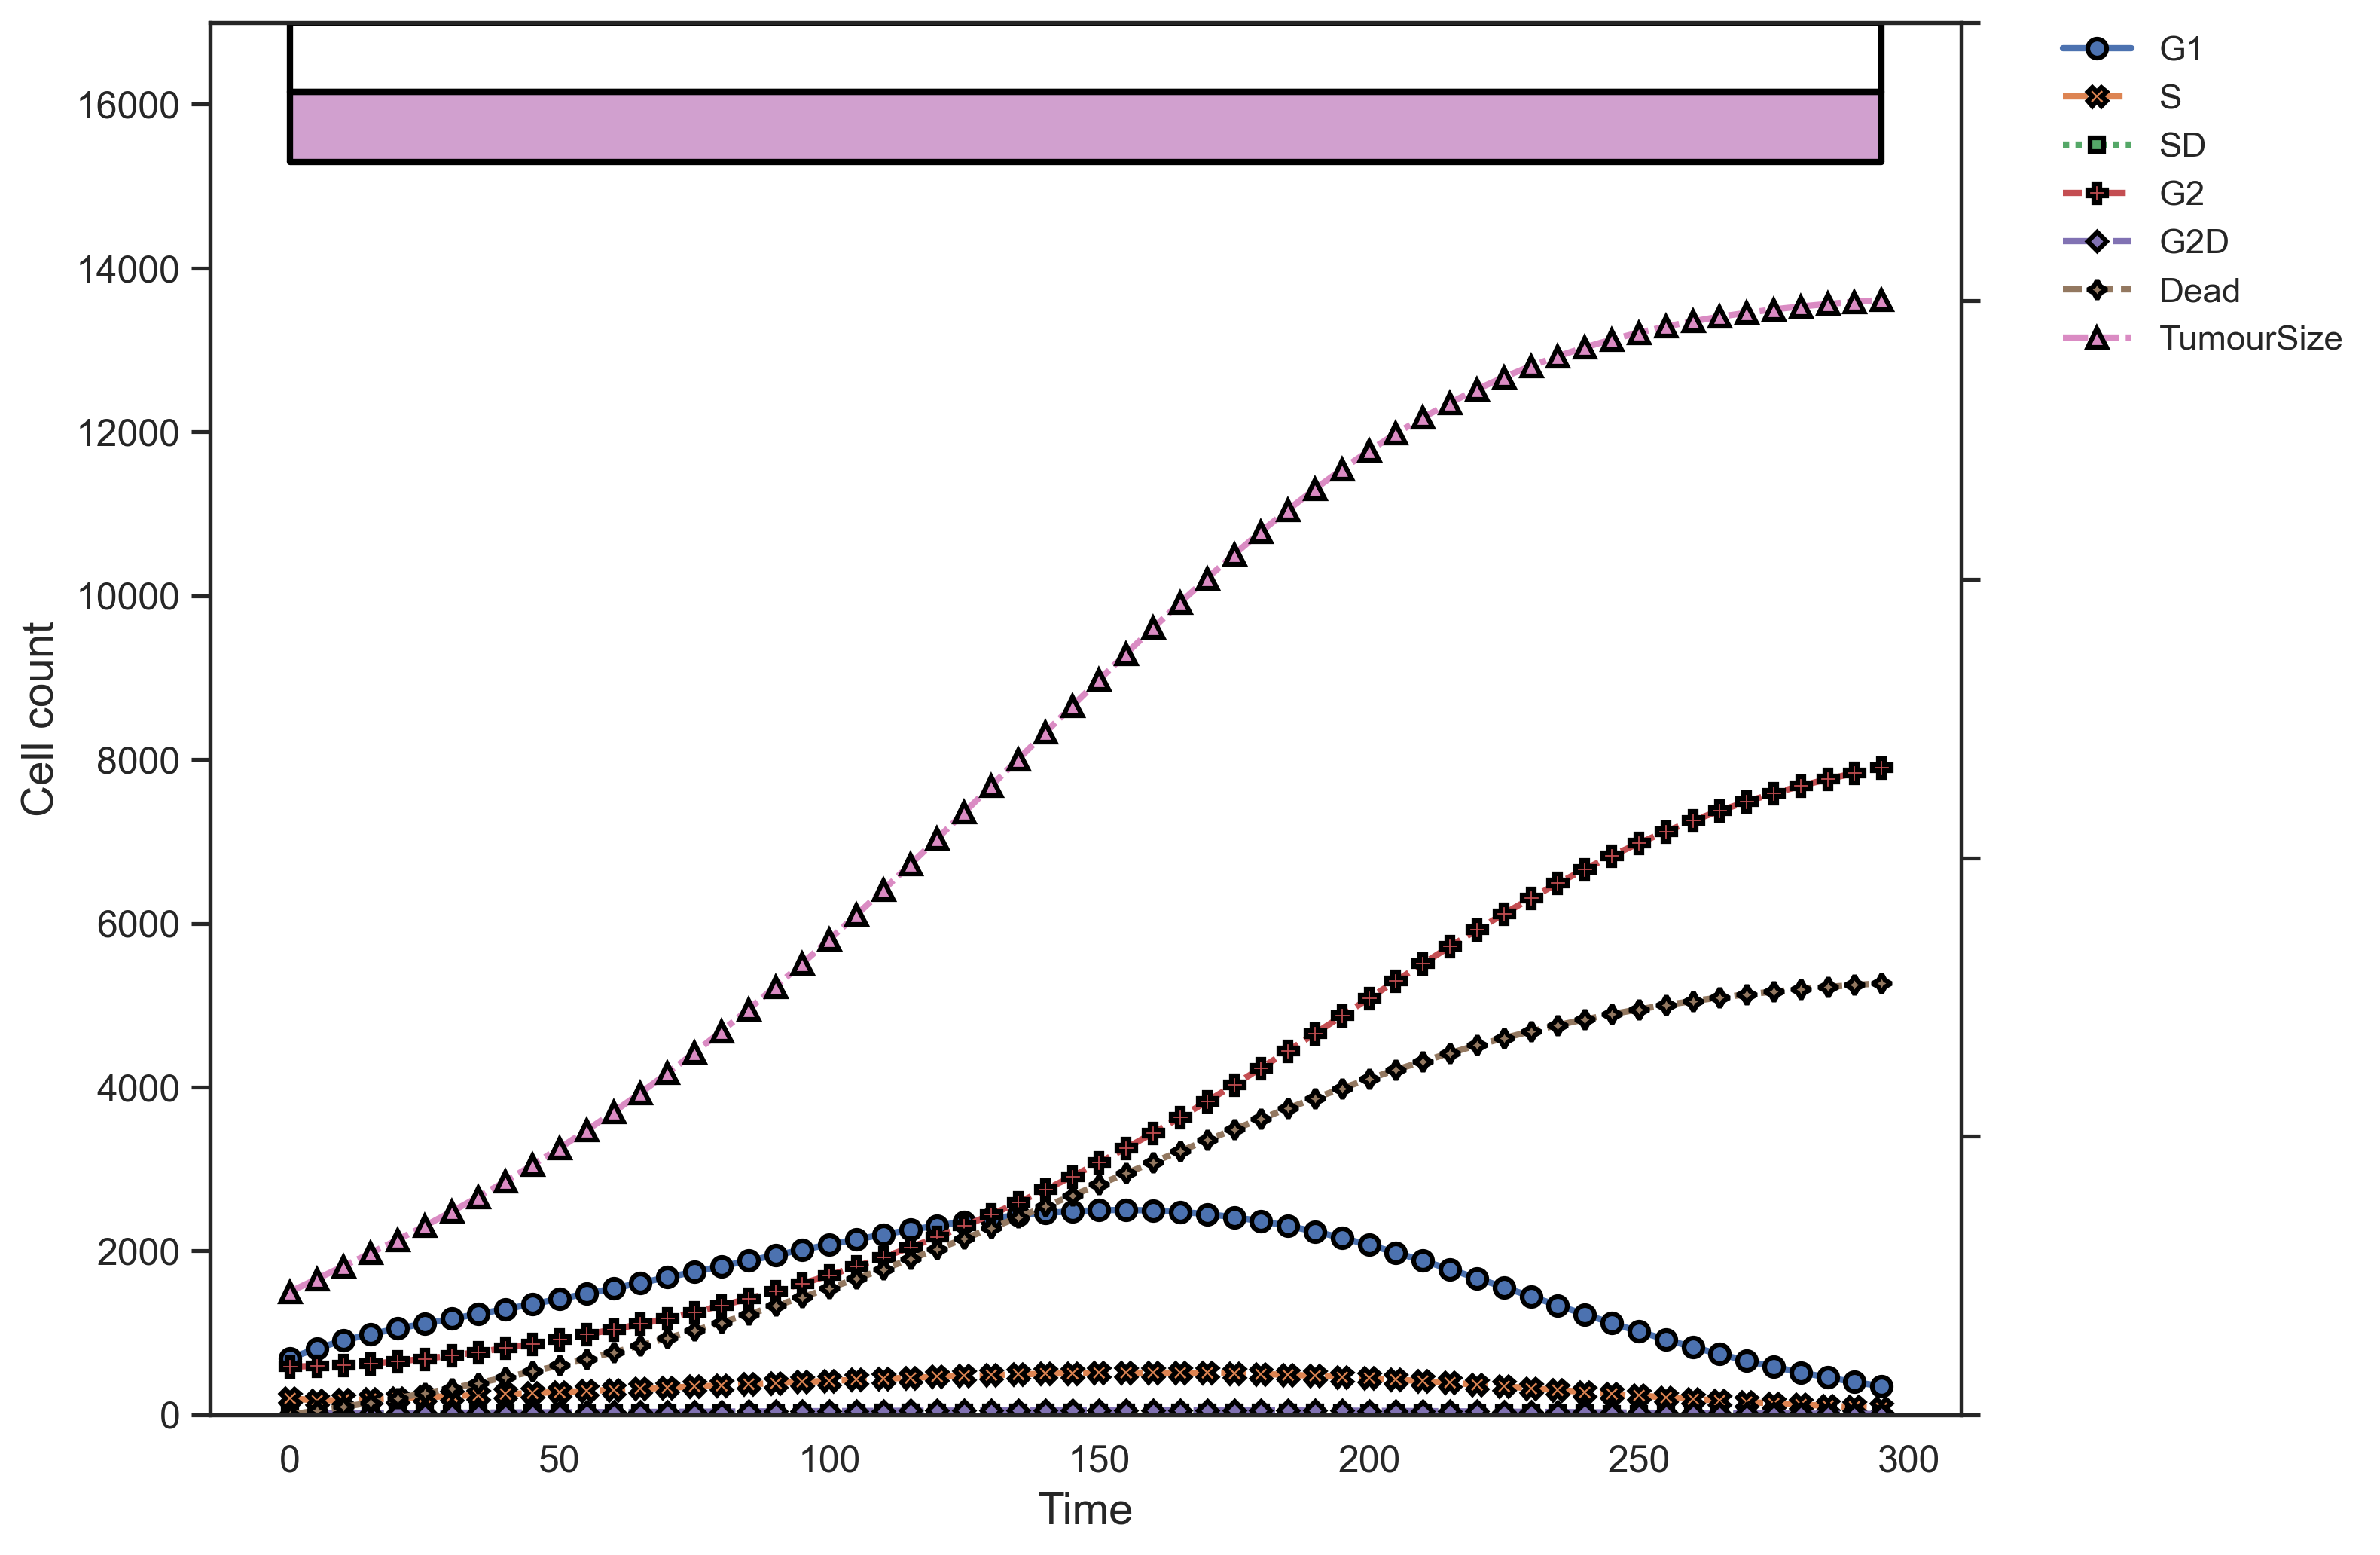

In [6]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,300,1,0]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()

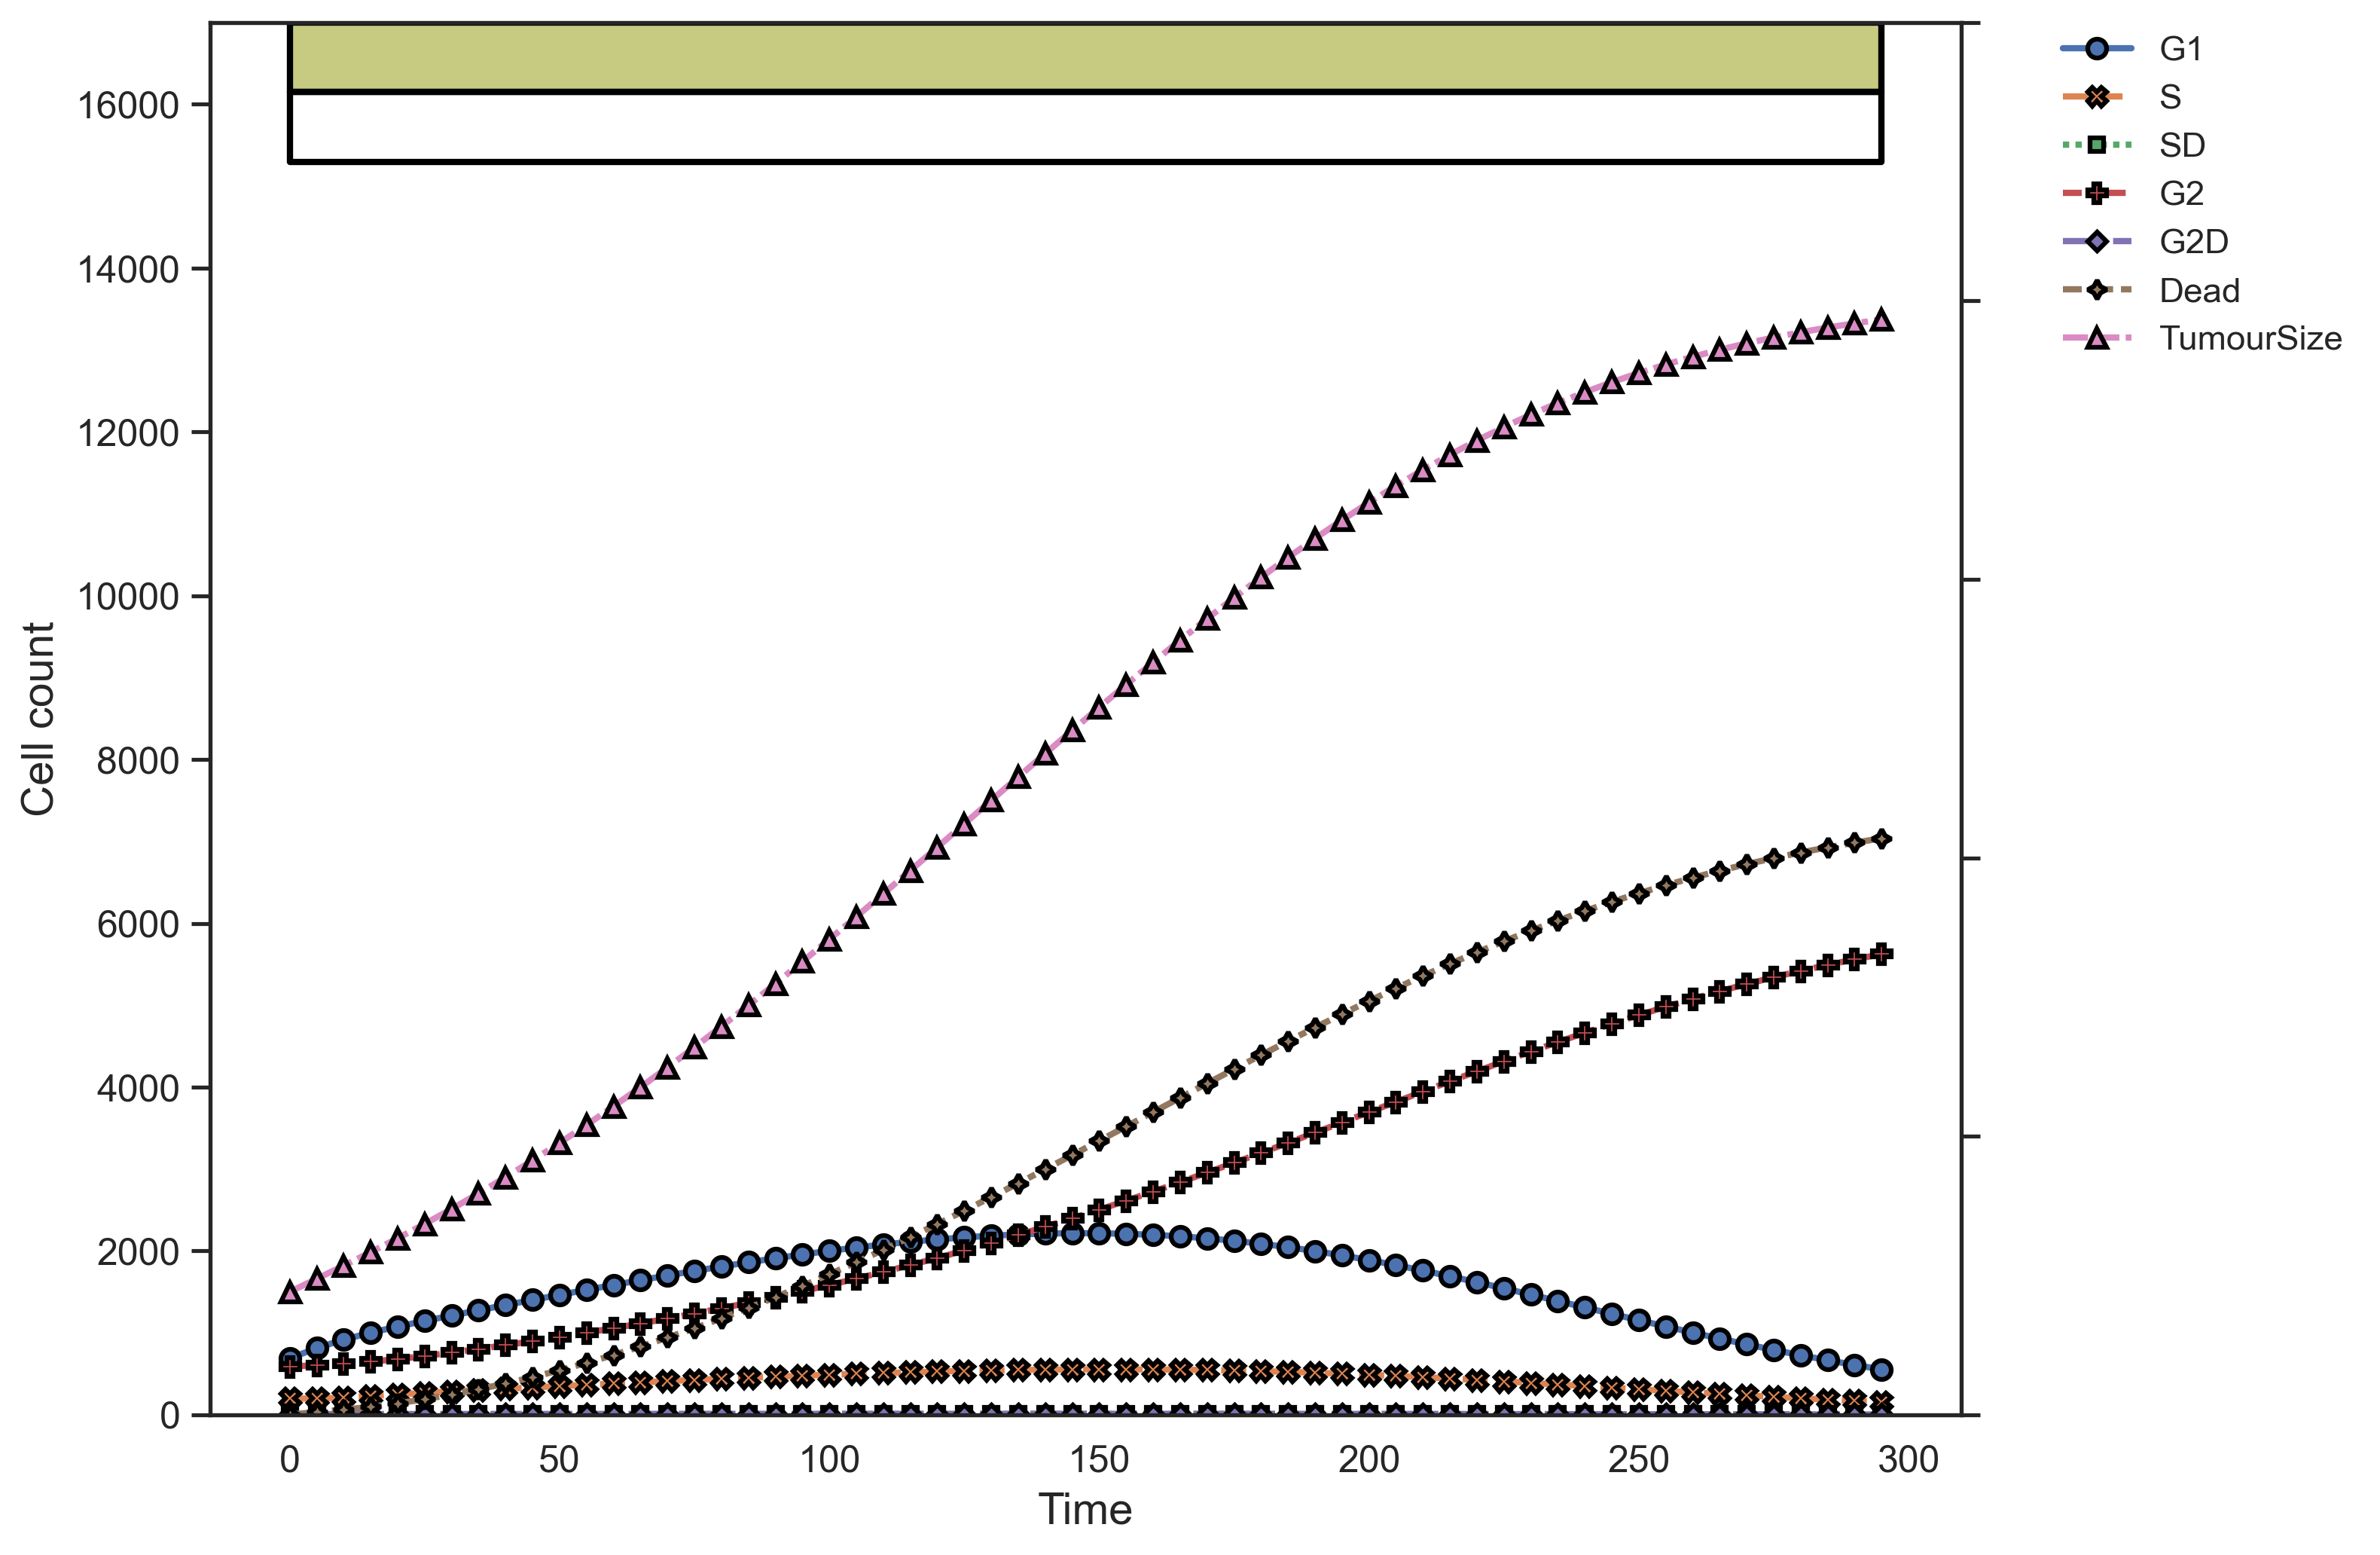

In [7]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,300,0,1]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()

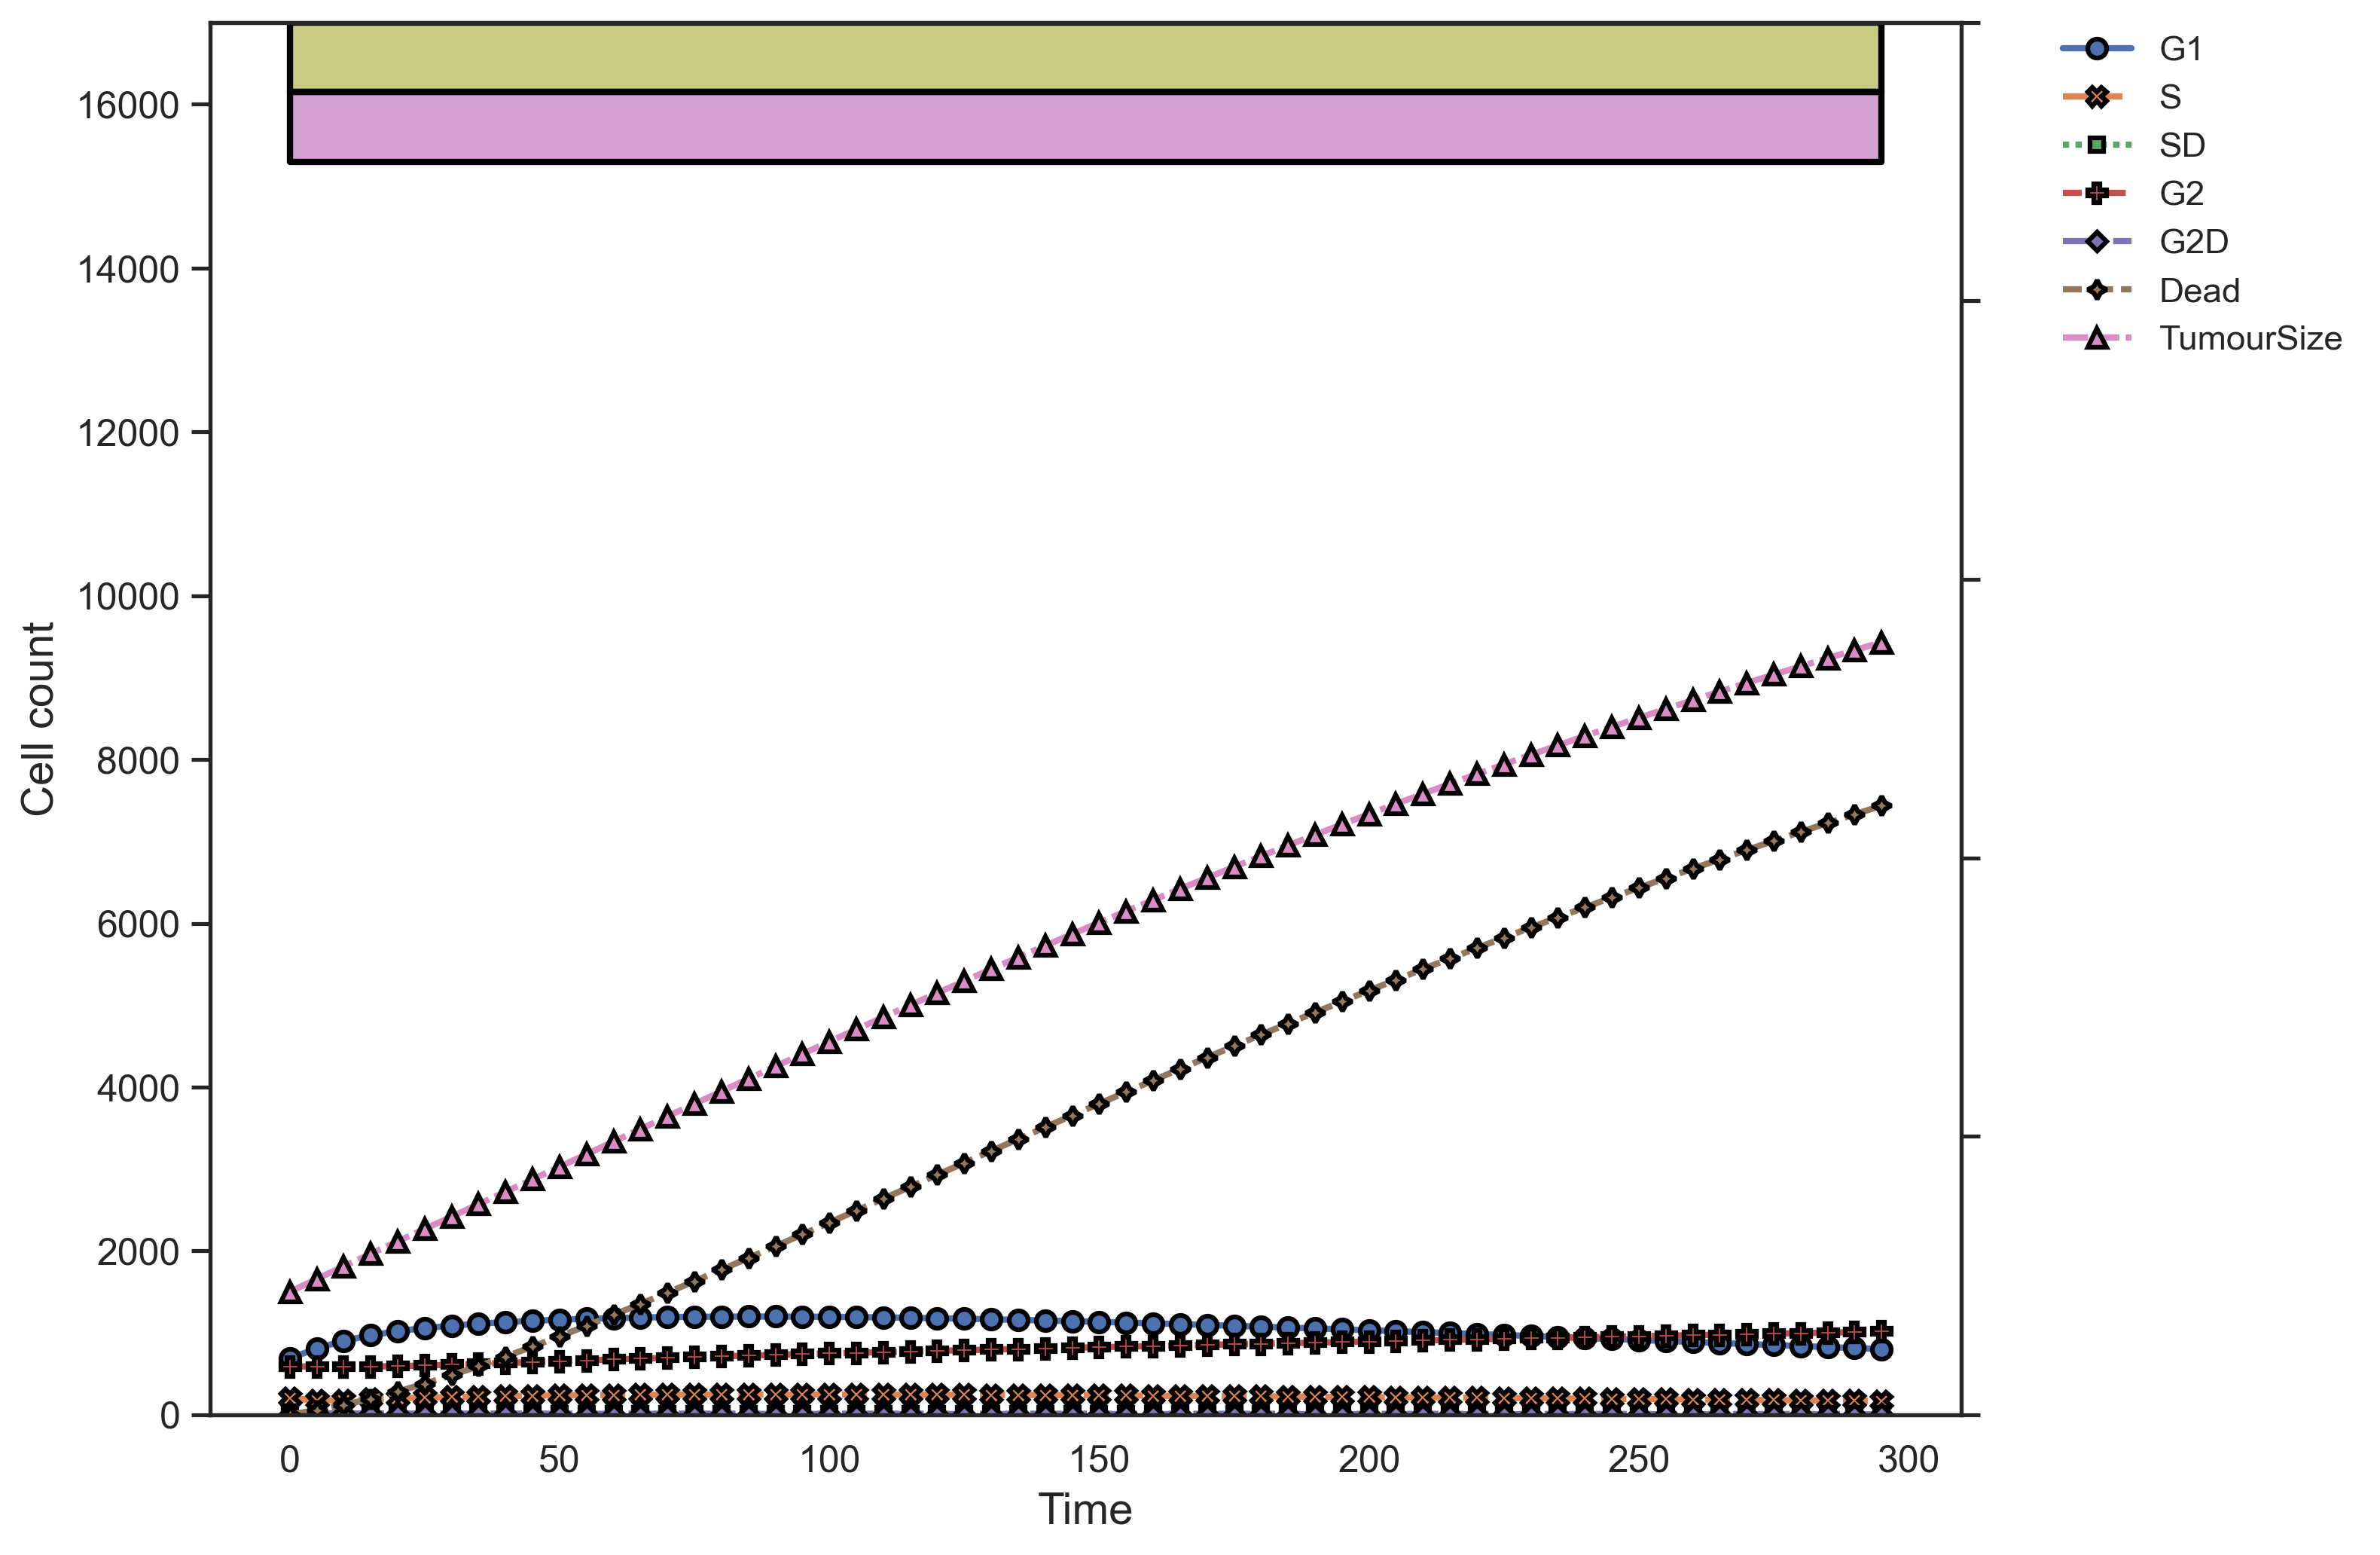

In [8]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,300,1,1]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()